In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openmc
from scipy.special import k1
from scipy.integrate import cumtrapz
from tqdm import tqdm, trange

from openmc.data import K_BOLTZMANN as kb

## Defining the Egelstaff-Schofield law and vibrational density

In [2]:
def egelstaff_schofield_impl(beta, wt, c):
    if beta < 1e-20:
        return 2.0*c*wt/np.pi
    else:
        return 4.0*c*wt/np.pi*np.sqrt(c**2+0.25)*np.sinh(beta/2.0)*k1(np.sqrt(c**2+0.25)*beta)
egelstaff_schofield = np.vectorize(egelstaff_schofield_impl)

def s_egelstaff_schofeld_impl(alpha, beta, wt, c):
    dd = np.sqrt(beta**2 + 4 * c**2 * wt**2 * alpha**2)
    
    karg = np.sqrt(c**2 + 0.25) * dd
    if karg > 10.0:
        # use asymptotic form. otherwise you get underflow
        return 2 * c * wt * alpha / np.pi * \
            np.exp(2 * c**2 * wt * alpha - beta/2.0 - karg) * \
            np.sqrt(c**2 + 0.25) / dd * np.sqrt(np.pi * 0.5 / karg)
    else:
        return 2 * c * wt * alpha / np.pi * \
            np.exp(2 * c**2 * wt * alpha - beta/2.0) * \
            np.sqrt(c**2 + 0.25) / dd * \
            k1(np.sqrt(c**2 + 0.25) * dd)
s_egelstaff_schofield = np.vectorize(s_egelstaff_schofeld_impl)

## Showing the vibrational spectrum from the MD code

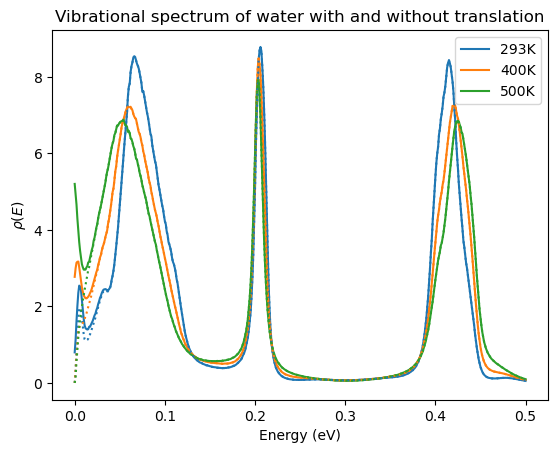

In [3]:
# These are the output from GROMACS. Note that the translational component is subtracted out,
# hence having the first value as zero.
rho_293 = [0.0000e+00, 3.4129e-01, 8.6926e-01, 1.3136e+00, 1.6955e+00, 1.9311e+00, 1.9547e+00, 1.8928e+00, 1.6823e+00, 1.4653e+00, 1.2719e+00, 1.1395e+00, 1.1034e+00, 1.1098e+00, 1.1244e+00, 1.1590e+00, 1.2461e+00, 1.2684e+00, 1.3426e+00, 1.4110e+00, 1.4770e+00, 1.5582e+00, 1.6464e+00, 1.7050e+00, 1.8056e+00, 1.8767e+00, 1.9807e+00, 2.0634e+00, 2.1571e+00, 2.2194e+00, 2.2970e+00, 2.3551e+00, 2.3990e+00, 2.4092e+00, 2.4215e+00, 2.4138e+00, 2.3936e+00, 2.3938e+00, 2.4279e+00, 2.4689e+00, 2.5380e+00, 2.6857e+00, 2.7901e+00, 2.9276e+00, 3.1020e+00, 3.3205e+00, 3.5562e+00, 3.7994e+00, 4.0496e+00, 4.3478e+00, 4.6552e+00, 4.9564e+00, 5.2669e+00, 5.5852e+00, 5.8684e+00, 6.2062e+00, 6.4834e+00, 6.7908e+00, 7.0601e+00, 7.4852e+00, 7.7408e+00, 7.8287e+00, 8.1319e+00, 8.2870e+00, 8.3807e+00, 8.5055e+00, 8.5357e+00, 8.5256e+00, 8.4387e+00, 8.3500e+00, 8.2936e+00, 8.2229e+00, 8.1040e+00, 7.9636e+00, 7.8398e+00, 7.6109e+00, 7.6289e+00, 7.5181e+00, 7.3771e+00, 7.2431e+00, 7.0914e+00, 6.9791e+00, 6.8405e+00, 6.6714e+00, 6.5135e+00, 6.4486e+00, 6.2201e+00, 6.0750e+00, 5.9413e+00, 5.8052e+00, 5.7197e+00, 5.5411e+00, 5.3523e+00, 5.1743e+00, 5.0552e+00, 4.9073e+00, 4.7777e+00, 4.6433e+00, 4.5413e+00, 4.3720e+00, 4.2294e+00, 4.1527e+00, 3.9652e+00, 3.8703e+00, 3.6855e+00, 3.6192e+00, 3.5295e+00, 3.4229e+00, 3.2627e+00, 3.1617e+00, 3.1031e+00, 3.0066e+00, 2.8857e+00, 2.7161e+00, 2.6134e+00, 2.4443e+00, 2.2832e+00, 2.0892e+00, 1.9518e+00, 1.7993e+00, 1.6405e+00, 1.4936e+00, 1.3575e+00, 1.2399e+00, 1.1436e+00, 1.0561e+00, 9.7299e-01, 9.0545e-01, 8.5094e-01, 7.9749e-01, 7.6514e-01, 7.1798e-01, 6.8538e-01, 6.5076e-01, 6.3075e-01, 6.0524e-01, 5.8555e-01, 5.6668e-01, 5.4779e-01, 5.3379e-01, 5.2516e-01, 5.1836e-01, 4.9716e-01, 4.9158e-01, 4.8231e-01, 4.7497e-01, 4.6107e-01, 4.6055e-01, 4.4936e-01, 4.4461e-01, 4.3603e-01, 4.3239e-01, 4.2215e-01, 4.1949e-01, 4.1412e-01, 4.1119e-01, 4.0590e-01, 4.0560e-01, 3.9703e-01, 3.9673e-01, 3.9188e-01, 3.9460e-01, 3.8913e-01, 3.8743e-01, 3.8641e-01, 3.8969e-01, 3.8673e-01, 3.9226e-01, 3.9058e-01, 3.9660e-01, 4.0156e-01, 4.0494e-01, 4.1074e-01, 4.1337e-01, 4.2542e-01, 4.2930e-01, 4.4653e-01, 4.4927e-01, 4.6712e-01, 4.7795e-01, 5.0295e-01, 5.2245e-01, 5.4676e-01, 5.6761e-01, 5.9635e-01, 6.3241e-01, 6.8388e-01, 7.3261e-01, 7.9228e-01, 8.5556e-01, 9.6214e-01, 1.0580e+00, 1.1863e+00, 1.3701e+00, 1.5992e+00, 1.8284e+00, 2.2330e+00, 2.7085e+00, 3.3522e+00, 4.2389e+00, 5.1341e+00, 6.2814e+00, 7.1029e+00, 7.7697e+00, 8.4534e+00, 8.6939e+00, 8.7860e+00, 8.6806e+00, 8.2726e+00, 7.7952e+00, 7.1454e+00, 6.3572e+00, 5.4584e+00, 4.4615e+00, 3.4738e+00, 2.6214e+00, 1.9536e+00, 1.4651e+00, 1.1306e+00, 8.8969e-01, 7.2199e-01, 5.8944e-01, 4.9176e-01, 4.0709e-01, 3.5478e-01, 3.0388e-01, 2.6933e-01, 2.3732e-01, 2.1461e-01, 1.8711e-01, 1.7245e-01, 1.5616e-01, 1.4456e-01, 1.3224e-01, 1.2450e-01, 1.1563e-01, 1.0898e-01, 1.0364e-01, 9.7408e-02, 9.4511e-02, 8.9105e-02, 8.7863e-02, 8.3325e-02, 8.3736e-02, 8.0353e-02, 8.1553e-02, 7.8308e-02, 8.0090e-02, 7.7896e-02, 7.8617e-02, 7.8328e-02, 8.0109e-02, 7.8743e-02, 8.1134e-02, 8.1170e-02, 8.2424e-02, 8.2934e-02, 8.4047e-02, 8.5539e-02, 8.5555e-02, 8.7104e-02, 8.8065e-02, 8.8637e-02, 8.9597e-02, 9.0385e-02, 9.0124e-02, 9.2098e-02, 9.1751e-02, 9.2050e-02, 9.2555e-02, 9.3478e-02, 9.2205e-02, 9.1822e-02, 8.9573e-02, 9.1155e-02, 8.8475e-02, 8.9659e-02, 8.7672e-02, 8.7739e-02, 8.5935e-02, 8.4255e-02, 8.2485e-02, 8.1334e-02, 8.0883e-02, 7.8675e-02, 7.8708e-02, 7.6543e-02, 7.5658e-02, 7.5156e-02, 7.4510e-02, 7.2809e-02, 7.3339e-02, 7.1299e-02, 7.2203e-02, 7.0456e-02, 7.1222e-02, 6.9361e-02, 7.0721e-02, 6.8907e-02, 7.0074e-02, 6.9223e-02, 7.0093e-02, 6.9786e-02, 7.0108e-02, 7.0346e-02, 7.0537e-02, 7.0937e-02, 7.2249e-02, 7.2748e-02, 7.2963e-02, 7.3953e-02, 7.4504e-02, 7.5964e-02, 7.6672e-02, 7.8288e-02, 7.8373e-02, 8.1021e-02, 8.0862e-02, 8.4168e-02, 8.3427e-02, 8.7197e-02, 8.6094e-02, 8.9679e-02, 8.9524e-02, 9.3299e-02, 9.3761e-02, 9.7131e-02, 9.7208e-02, 1.0018e-01, 1.0079e-01, 1.0403e-01, 1.0517e-01, 1.0824e-01, 1.0841e-01, 1.1075e-01, 1.1387e-01, 1.1534e-01, 1.1824e-01, 1.1811e-01, 1.2185e-01, 1.2372e-01, 1.2580e-01, 1.2609e-01, 1.3014e-01, 1.2955e-01, 1.3438e-01, 1.3285e-01, 1.3883e-01, 1.3769e-01, 1.4186e-01, 1.4209e-01, 1.4790e-01, 1.4681e-01, 1.5262e-01, 1.5077e-01, 1.5664e-01, 1.5809e-01, 1.6254e-01, 1.6372e-01, 1.6934e-01, 1.7153e-01, 1.7810e-01, 1.8203e-01, 1.8715e-01, 1.9484e-01, 2.0057e-01, 2.0900e-01, 2.1885e-01, 2.2999e-01, 2.3980e-01, 2.5483e-01, 2.6223e-01, 2.8318e-01, 2.9515e-01, 3.2338e-01, 3.3249e-01, 3.6316e-01, 3.8386e-01, 4.2346e-01, 4.5492e-01, 5.0852e-01, 5.4706e-01, 6.1925e-01, 6.7914e-01, 7.6893e-01, 8.5835e-01, 9.7633e-01, 1.1196e+00, 1.2891e+00, 1.4889e+00, 1.7038e+00, 1.9893e+00, 2.2729e+00, 2.6188e+00, 3.0012e+00, 3.4110e+00, 3.7685e+00, 4.2434e+00, 4.6446e+00, 5.0642e+00, 5.4004e+00, 5.7482e+00, 5.9990e+00, 6.1768e+00, 6.4985e+00, 6.6503e+00, 6.8964e+00, 7.0515e+00, 7.2338e+00, 7.4868e+00, 7.5959e+00, 7.7655e+00, 7.9997e+00, 8.2474e+00, 8.3707e+00, 8.4366e+00, 8.3647e+00, 8.2528e+00, 8.0654e+00, 7.8766e+00, 7.6111e+00, 7.1705e+00, 6.8543e+00, 6.3339e+00, 5.9389e+00, 5.5996e+00, 5.1948e+00, 4.8874e+00, 4.5533e+00, 4.2933e+00, 4.0300e+00, 3.7224e+00, 3.5566e+00, 3.3415e+00, 3.1411e+00, 3.0025e+00, 2.8166e+00, 2.6373e+00, 2.4516e+00, 2.2601e+00, 2.0577e+00, 1.8848e+00, 1.6949e+00, 1.4940e+00, 1.2633e+00, 1.0761e+00, 9.0287e-01, 7.5816e-01, 6.1420e-01, 5.0712e-01, 4.1313e-01, 3.4800e-01, 2.8975e-01, 2.4806e-01, 2.1275e-01, 1.8875e-01, 1.6867e-01, 1.5363e-01, 1.4343e-01, 1.3277e-01, 1.2786e-01, 1.2086e-01, 1.2091e-01, 1.1699e-01, 1.1861e-01, 1.1501e-01, 1.1884e-01, 1.1615e-01, 1.2091e-01, 1.1932e-01, 1.2417e-01, 1.2253e-01, 1.2844e-01, 1.2591e-01, 1.3142e-01, 1.2891e-01, 1.3306e-01, 1.3073e-01, 1.3387e-01, 1.3186e-01, 1.3295e-01, 1.2954e-01, 1.2839e-01, 1.2381e-01, 1.2311e-01, 1.2021e-01, 1.1510e-01, 1.1186e-01, 1.0718e-01, 1.0289e-01, 9.7670e-02, 9.3496e-02, 8.8865e-02, 8.6066e-02, 7.8596e-02, 7.6247e-02, 6.9577e-02, 6.8077e-02, 6.2076e-02, 6.0474e-02, 5.3943e-02]
rho_400 = [0.0000e+00, 3.6149e-01, 7.6039e-01, 1.0610e+00, 1.3407e+00, 1.4485e+00, 1.5050e+00, 1.5176e+00, 1.5291e+00, 1.5694e+00, 1.6083e+00, 1.6749e+00, 1.7400e+00, 1.8142e+00, 1.8990e+00, 1.9822e+00, 2.0653e+00, 2.1620e+00, 2.2435e+00, 2.3396e+00, 2.4446e+00, 2.5426e+00, 2.6481e+00, 2.7477e+00, 2.8471e+00, 2.9179e+00, 3.0511e+00, 3.1402e+00, 3.2566e+00, 3.3224e+00, 3.4431e+00, 3.5416e+00, 3.6092e+00, 3.6951e+00, 3.8054e+00, 3.8906e+00, 3.9816e+00, 4.1616e+00, 4.2741e+00, 4.4333e+00, 4.5949e+00, 4.7790e+00, 4.9869e+00, 5.0848e+00, 5.2910e+00, 5.5300e+00, 5.6611e+00, 5.8989e+00, 6.0689e+00, 6.2177e+00, 6.3564e+00, 6.5184e+00, 6.6913e+00, 6.7975e+00, 6.8701e+00, 6.9655e+00, 7.0555e+00, 7.1310e+00, 7.1885e+00, 7.2240e+00, 7.2092e+00, 7.2117e+00, 7.2213e+00, 7.1673e+00, 7.1319e+00, 7.0333e+00, 6.9669e+00, 6.9282e+00, 6.8962e+00, 6.7880e+00, 6.6847e+00, 6.5615e+00, 6.5143e+00, 6.4280e+00, 6.2985e+00, 6.2106e+00, 6.0544e+00, 5.9692e+00, 5.8280e+00, 5.7163e+00, 5.5997e+00, 5.4995e+00, 5.3465e+00, 5.2411e+00, 5.1561e+00, 4.9929e+00, 4.8927e+00, 4.7590e+00, 4.6422e+00, 4.5285e+00, 4.4413e+00, 4.3428e+00, 4.2066e+00, 4.1034e+00, 3.9657e+00, 3.8333e+00, 3.7278e+00, 3.6019e+00, 3.4989e+00, 3.3776e+00, 3.2658e+00, 3.1590e+00, 3.0374e+00, 2.9182e+00, 2.7950e+00, 2.6917e+00, 2.5824e+00, 2.4491e+00, 2.3487e+00, 2.2370e+00, 2.1276e+00, 2.0216e+00, 1.9291e+00, 1.8192e+00, 1.7178e+00, 1.6118e+00, 1.5052e+00, 1.4163e+00, 1.3093e+00, 1.2500e+00, 1.1743e+00, 1.1222e+00, 1.0526e+00, 1.0017e+00, 9.5847e-01, 9.1178e-01, 8.7567e-01, 8.4223e-01, 8.0782e-01, 7.8236e-01, 7.6238e-01, 7.3930e-01, 7.0889e-01, 6.9663e-01, 6.7784e-01, 6.5373e-01, 6.4801e-01, 6.2955e-01, 6.2172e-01, 6.0783e-01, 6.0059e-01, 5.9258e-01, 5.8551e-01, 5.7189e-01, 5.6941e-01, 5.6588e-01, 5.5876e-01, 5.4955e-01, 5.4413e-01, 5.4093e-01, 5.3743e-01, 5.3170e-01, 5.2932e-01, 5.2314e-01, 5.2448e-01, 5.1920e-01, 5.1953e-01, 5.1668e-01, 5.1315e-01, 5.1044e-01, 5.0814e-01, 5.0662e-01, 5.0432e-01, 5.0398e-01, 5.0019e-01, 5.0300e-01, 5.0567e-01, 5.0456e-01, 5.0632e-01, 5.0552e-01, 5.0839e-01, 5.1126e-01, 5.1523e-01, 5.2357e-01, 5.2854e-01, 5.3694e-01, 5.4289e-01, 5.5721e-01, 5.6473e-01, 5.8720e-01, 6.0974e-01, 6.2645e-01, 6.5606e-01, 6.8523e-01, 7.2118e-01, 7.5996e-01, 8.0836e-01, 8.7530e-01, 9.3819e-01, 1.0373e+00, 1.1403e+00, 1.2775e+00, 1.4369e+00, 1.6434e+00, 1.9122e+00, 2.2797e+00, 2.7026e+00, 3.2842e+00, 3.9332e+00, 4.7787e+00, 5.8344e+00, 6.7826e+00, 7.6498e+00, 8.2546e+00, 8.4856e+00, 8.3338e+00, 8.0504e+00, 7.5034e+00, 6.8084e+00, 6.0921e+00, 5.3033e+00, 4.4698e+00, 3.6721e+00, 2.9996e+00, 2.4043e+00, 1.9387e+00, 1.5826e+00, 1.3121e+00, 1.0980e+00, 9.2776e-01, 7.9069e-01, 6.8521e-01, 5.9964e-01, 5.3357e-01, 4.7235e-01, 4.2829e-01, 3.8877e-01, 3.5921e-01, 3.2594e-01, 3.0383e-01, 2.8005e-01, 2.6379e-01, 2.4588e-01, 2.3261e-01, 2.2037e-01, 2.1177e-01, 2.0126e-01, 1.9483e-01, 1.8682e-01, 1.8034e-01, 1.7393e-01, 1.6837e-01, 1.6327e-01, 1.6047e-01, 1.5530e-01, 1.5215e-01, 1.5143e-01, 1.4601e-01, 1.4518e-01, 1.4105e-01, 1.4030e-01, 1.3766e-01, 1.3664e-01, 1.3367e-01, 1.3348e-01, 1.3100e-01, 1.3031e-01, 1.2580e-01, 1.2646e-01, 1.2324e-01, 1.2380e-01, 1.1911e-01, 1.1923e-01, 1.1643e-01, 1.1489e-01, 1.1215e-01, 1.1057e-01, 1.0853e-01, 1.0711e-01, 1.0350e-01, 1.0175e-01, 9.9917e-02, 9.8107e-02, 9.7154e-02, 9.5719e-02, 9.2223e-02, 9.0995e-02, 8.9000e-02, 8.7616e-02, 8.6292e-02, 8.3862e-02, 8.3054e-02, 8.0519e-02, 8.0147e-02, 7.6707e-02, 7.7446e-02, 7.4539e-02, 7.4425e-02, 7.1806e-02, 7.2599e-02, 7.0413e-02, 7.0946e-02, 6.8211e-02, 6.9043e-02, 6.6989e-02, 6.7868e-02, 6.6425e-02, 6.6913e-02, 6.5712e-02, 6.6601e-02, 6.5258e-02, 6.6182e-02, 6.5531e-02, 6.5838e-02, 6.5886e-02, 6.6767e-02, 6.7604e-02, 6.7591e-02, 6.8912e-02, 6.8688e-02, 7.0108e-02, 6.9968e-02, 7.1442e-02, 7.1825e-02, 7.4186e-02, 7.4046e-02, 7.6363e-02, 7.5837e-02, 7.9663e-02, 7.9157e-02, 8.1840e-02, 8.2444e-02, 8.5540e-02, 8.6710e-02, 8.9897e-02, 8.9955e-02, 9.3017e-02, 9.3640e-02, 9.8028e-02, 9.9434e-02, 1.0243e-01, 1.0360e-01, 1.0672e-01, 1.0891e-01, 1.1139e-01, 1.1427e-01, 1.1701e-01, 1.2032e-01, 1.2248e-01, 1.2664e-01, 1.2863e-01, 1.3158e-01, 1.3460e-01, 1.3882e-01, 1.4070e-01, 1.4528e-01, 1.4850e-01, 1.5399e-01, 1.5606e-01, 1.6139e-01, 1.6242e-01, 1.6995e-01, 1.7199e-01, 1.7804e-01, 1.8119e-01, 1.8696e-01, 1.8992e-01, 1.9719e-01, 2.0274e-01, 2.0887e-01, 2.1472e-01, 2.2188e-01, 2.2896e-01, 2.3842e-01, 2.4382e-01, 2.5343e-01, 2.6341e-01, 2.7175e-01, 2.8400e-01, 2.9620e-01, 3.1058e-01, 3.2072e-01, 3.4099e-01, 3.6010e-01, 3.8224e-01, 3.9909e-01, 4.2533e-01, 4.4409e-01, 4.7897e-01, 5.1133e-01, 5.4678e-01, 5.8797e-01, 6.3401e-01, 6.8849e-01, 7.5316e-01, 8.2439e-01, 9.0385e-01, 1.0046e+00, 1.1128e+00, 1.2329e+00, 1.3734e+00, 1.5316e+00, 1.7028e+00, 1.9010e+00, 2.1171e+00, 2.3394e+00, 2.5992e+00, 2.8792e+00, 3.1575e+00, 3.4232e+00, 3.6637e+00, 3.9334e+00, 4.1980e+00, 4.3864e+00, 4.5305e+00, 4.7306e+00, 4.8761e+00, 4.9987e+00, 5.1837e+00, 5.3030e+00, 5.4941e+00, 5.7158e+00, 5.9107e+00, 6.1472e+00, 6.3552e+00, 6.5785e+00, 6.7980e+00, 6.9485e+00, 7.1105e+00, 7.2399e+00, 7.2453e+00, 7.2738e+00, 7.2486e+00, 7.1194e+00, 6.9874e+00, 6.9110e+00, 6.7589e+00, 6.5563e+00, 6.3392e+00, 6.1261e+00, 5.9246e+00, 5.6740e+00, 5.4724e+00, 5.2760e+00, 5.0558e+00, 4.8106e+00, 4.5973e+00, 4.3531e+00, 4.1074e+00, 3.8435e+00, 3.5607e+00, 3.2714e+00, 2.9588e+00, 2.6418e+00, 2.3385e+00, 2.0347e+00, 1.7508e+00, 1.5018e+00, 1.2784e+00, 1.0938e+00, 9.3054e-01, 8.0551e-01, 7.0110e-01, 6.1881e-01, 5.4943e-01, 4.9865e-01, 4.5197e-01, 4.2198e-01, 3.9138e-01, 3.6995e-01, 3.5077e-01, 3.3836e-01, 3.2467e-01, 3.1425e-01, 3.0564e-01, 2.9729e-01, 2.9275e-01, 2.8606e-01, 2.8273e-01, 2.7664e-01, 2.7183e-01, 2.6573e-01, 2.6117e-01, 2.5838e-01, 2.5293e-01, 2.4737e-01, 2.4175e-01, 2.3501e-01, 2.2877e-01, 2.2139e-01, 2.1663e-01, 2.0785e-01, 2.0229e-01, 1.9505e-01, 1.8608e-01, 1.7908e-01, 1.7159e-01, 1.6286e-01, 1.5477e-01, 1.4737e-01, 1.4200e-01, 1.3386e-01, 1.2575e-01, 1.1833e-01, 1.1275e-01, 1.0508e-01, 9.9613e-02, 9.2823e-02, 8.7590e-02, 8.2135e-02, 7.7357e-02]
rho_500 = [0.0000e+00, 1.4627e-01, 5.5429e-01, 8.7218e-01, 1.1947e+00, 1.4424e+00, 1.6674e+00, 1.8593e+00, 1.9922e+00, 2.1557e+00, 2.2853e+00, 2.4340e+00, 2.5545e+00, 2.7024e+00, 2.8112e+00, 2.9623e+00, 3.0250e+00, 3.1598e+00, 3.2873e+00, 3.4177e+00, 3.5107e+00, 3.6805e+00, 3.7682e+00, 3.9128e+00, 4.0448e+00, 4.1360e+00, 4.2959e+00, 4.4179e+00, 4.5168e+00, 4.6212e+00, 4.7461e+00, 4.8662e+00, 4.9968e+00, 5.1193e+00, 5.2361e+00, 5.3970e+00, 5.5229e+00, 5.6154e+00, 5.7520e+00, 5.9053e+00, 6.0313e+00, 6.1576e+00, 6.2627e+00, 6.3301e+00, 6.4819e+00, 6.5324e+00, 6.6335e+00, 6.7282e+00, 6.7235e+00, 6.7747e+00, 6.8060e+00, 6.8359e+00, 6.8377e+00, 6.8616e+00, 6.8812e+00, 6.8122e+00, 6.7482e+00, 6.7267e+00, 6.7030e+00, 6.5645e+00, 6.5930e+00, 6.5295e+00, 6.4011e+00, 6.3700e+00, 6.2975e+00, 6.1912e+00, 6.1259e+00, 6.0114e+00, 5.8667e+00, 5.8384e+00, 5.7252e+00, 5.6292e+00, 5.4958e+00, 5.4123e+00, 5.3081e+00, 5.1686e+00, 5.0842e+00, 4.9809e+00, 4.8935e+00, 4.8006e+00, 4.6753e+00, 4.5637e+00, 4.4258e+00, 4.3586e+00, 4.2305e+00, 4.1208e+00, 4.0237e+00, 3.9135e+00, 3.7979e+00, 3.6927e+00, 3.6189e+00, 3.4736e+00, 3.3670e+00, 3.2410e+00, 3.1398e+00, 3.0273e+00, 2.9072e+00, 2.7796e+00, 2.6795e+00, 2.5584e+00, 2.4419e+00, 2.3268e+00, 2.2245e+00, 2.1358e+00, 2.0136e+00, 1.9224e+00, 1.8332e+00, 1.7313e+00, 1.6782e+00, 1.5897e+00, 1.5141e+00, 1.4556e+00, 1.3730e+00, 1.3169e+00, 1.2547e+00, 1.2090e+00, 1.1522e+00, 1.1104e+00, 1.0693e+00, 1.0165e+00, 9.8866e-01, 9.5114e-01, 9.1650e-01, 8.8974e-01, 8.5736e-01, 8.3318e-01, 8.0471e-01, 7.8898e-01, 7.6020e-01, 7.4718e-01, 7.2977e-01, 7.1689e-01, 6.9737e-01, 6.8240e-01, 6.7077e-01, 6.5564e-01, 6.5204e-01, 6.3486e-01, 6.2537e-01, 6.1821e-01, 6.1334e-01, 6.1010e-01, 5.9617e-01, 5.9388e-01, 5.9112e-01, 5.8766e-01, 5.8279e-01, 5.7776e-01, 5.7845e-01, 5.7326e-01, 5.7409e-01, 5.6877e-01, 5.7032e-01, 5.7205e-01, 5.7079e-01, 5.7051e-01, 5.6963e-01, 5.6958e-01, 5.7439e-01, 5.7170e-01, 5.7201e-01, 5.7449e-01, 5.7465e-01, 5.7554e-01, 5.8306e-01, 5.8178e-01, 5.8861e-01, 5.8972e-01, 5.9489e-01, 6.0363e-01, 6.0559e-01, 6.1507e-01, 6.1913e-01, 6.2661e-01, 6.4046e-01, 6.5451e-01, 6.6423e-01, 6.7571e-01, 6.9283e-01, 7.1621e-01, 7.4028e-01, 7.6447e-01, 7.9136e-01, 8.2778e-01, 8.6813e-01, 9.1222e-01, 9.7646e-01, 1.0444e+00, 1.1305e+00, 1.2335e+00, 1.3449e+00, 1.4966e+00, 1.6720e+00, 1.9224e+00, 2.2006e+00, 2.5634e+00, 3.0138e+00, 3.6237e+00, 4.3347e+00, 5.1372e+00, 6.0396e+00, 6.8747e+00, 7.5732e+00, 7.9106e+00, 7.9295e+00, 7.5629e+00, 6.9014e+00, 6.1057e+00, 5.2830e+00, 4.4845e+00, 3.7444e+00, 3.1404e+00, 2.6348e+00, 2.2170e+00, 1.8687e+00, 1.6046e+00, 1.3755e+00, 1.2041e+00, 1.0599e+00, 9.4892e-01, 8.4327e-01, 7.6781e-01, 7.0596e-01, 6.3932e-01, 5.9557e-01, 5.5003e-01, 5.1875e-01, 4.8385e-01, 4.5568e-01, 4.2766e-01, 4.0283e-01, 3.8497e-01, 3.6558e-01, 3.4835e-01, 3.3568e-01, 3.1861e-01, 3.0527e-01, 2.9214e-01, 2.8395e-01, 2.7291e-01, 2.6221e-01, 2.5356e-01, 2.4330e-01, 2.3496e-01, 2.2740e-01, 2.1927e-01, 2.1312e-01, 2.0444e-01, 1.9980e-01, 1.9304e-01, 1.8804e-01, 1.8143e-01, 1.7508e-01, 1.7233e-01, 1.6624e-01, 1.6284e-01, 1.5647e-01, 1.5332e-01, 1.4796e-01, 1.4509e-01, 1.4089e-01, 1.3816e-01, 1.3167e-01, 1.2844e-01, 1.2507e-01, 1.2247e-01, 1.1839e-01, 1.1534e-01, 1.1056e-01, 1.0900e-01, 1.0611e-01, 1.0262e-01, 9.9772e-02, 9.7322e-02, 9.4291e-02, 9.1537e-02, 8.9536e-02, 8.6933e-02, 8.5050e-02, 8.2373e-02, 8.1506e-02, 7.8027e-02, 7.6742e-02, 7.4198e-02, 7.3774e-02, 7.0713e-02, 7.1164e-02, 6.8258e-02, 6.8127e-02, 6.5789e-02, 6.4900e-02, 6.4153e-02, 6.3227e-02, 6.1455e-02, 6.1406e-02, 6.0747e-02, 6.0286e-02, 5.9399e-02, 5.9082e-02, 5.8427e-02, 5.8110e-02, 5.7916e-02, 5.7460e-02, 5.8212e-02, 5.7738e-02, 5.8076e-02, 5.7869e-02, 5.8556e-02, 5.8455e-02, 5.9812e-02, 5.9870e-02, 6.1476e-02, 6.1260e-02, 6.3279e-02, 6.3451e-02, 6.5398e-02, 6.5993e-02, 6.7569e-02, 6.9359e-02, 7.1459e-02, 7.2108e-02, 7.4693e-02, 7.5906e-02, 7.8392e-02, 7.9873e-02, 8.2152e-02, 8.3792e-02, 8.6438e-02, 8.8927e-02, 9.1605e-02, 9.3643e-02, 9.7109e-02, 9.9844e-02, 1.0187e-01, 1.0550e-01, 1.0771e-01, 1.1148e-01, 1.1331e-01, 1.1796e-01, 1.2061e-01, 1.2488e-01, 1.2725e-01, 1.3211e-01, 1.3533e-01, 1.3937e-01, 1.4313e-01, 1.4773e-01, 1.5235e-01, 1.5789e-01, 1.6145e-01, 1.6572e-01, 1.7059e-01, 1.7657e-01, 1.8222e-01, 1.8958e-01, 1.9461e-01, 1.9929e-01, 2.0627e-01, 2.1176e-01, 2.1804e-01, 2.2730e-01, 2.3502e-01, 2.4383e-01, 2.5206e-01, 2.6364e-01, 2.7145e-01, 2.8070e-01, 2.9380e-01, 3.0662e-01, 3.2124e-01, 3.3160e-01, 3.4568e-01, 3.6331e-01, 3.7953e-01, 3.9746e-01, 4.1929e-01, 4.3872e-01, 4.6678e-01, 4.8928e-01, 5.1889e-01, 5.5002e-01, 5.8385e-01, 6.1987e-01, 6.6699e-01, 7.1057e-01, 7.6637e-01, 8.2774e-01, 9.0391e-01, 9.8309e-01, 1.0646e+00, 1.1699e+00, 1.2760e+00, 1.3856e+00, 1.5191e+00, 1.6721e+00, 1.8209e+00, 1.9833e+00, 2.1466e+00, 2.3357e+00, 2.5407e+00, 2.7060e+00, 2.8681e+00, 3.0325e+00, 3.2090e+00, 3.3176e+00, 3.4393e+00, 3.5943e+00, 3.6597e+00, 3.8010e+00, 3.9290e+00, 4.1105e+00, 4.3067e+00, 4.5318e+00, 4.7522e+00, 4.9966e+00, 5.2716e+00, 5.5084e+00, 5.7333e+00, 5.9830e+00, 6.1917e+00, 6.3966e+00, 6.6125e+00, 6.7010e+00, 6.8301e+00, 6.8061e+00, 6.8623e+00, 6.8198e+00, 6.7489e+00, 6.6793e+00, 6.5534e+00, 6.5112e+00, 6.3709e+00, 6.2182e+00, 6.0689e+00, 5.9118e+00, 5.7215e+00, 5.5220e+00, 5.3437e+00, 5.1643e+00, 4.8982e+00, 4.6752e+00, 4.3850e+00, 4.1009e+00, 3.7990e+00, 3.4504e+00, 3.1361e+00, 2.7800e+00, 2.4687e+00, 2.1948e+00, 1.9056e+00, 1.6880e+00, 1.4925e+00, 1.3232e+00, 1.1942e+00, 1.0693e+00, 9.8424e-01, 9.0408e-01, 8.4341e-01, 7.8489e-01, 7.4422e-01, 7.0052e-01, 6.6739e-01, 6.3412e-01, 6.1026e-01, 5.8736e-01, 5.6757e-01, 5.4474e-01, 5.2222e-01, 5.0642e-01, 4.8759e-01, 4.7144e-01, 4.5676e-01, 4.3622e-01, 4.1914e-01, 4.0640e-01, 3.9130e-01, 3.7411e-01, 3.5688e-01, 3.4390e-01, 3.2768e-01, 3.1431e-01, 2.9954e-01, 2.8597e-01, 2.7038e-01, 2.5779e-01, 2.4187e-01, 2.3199e-01, 2.1831e-01, 2.0656e-01, 1.9602e-01, 1.8383e-01, 1.7467e-01, 1.6442e-01, 1.5469e-01, 1.4494e-01, 1.3489e-01, 1.2715e-01, 1.1838e-01, 1.1227e-01, 1.0453e-01, 9.7432e-02]
Evals = np.arange(len(rho_293)) * 1e-3 # delta E = 1e-3, start from 0

# Translational weights and diffusion constants vs temperature, also from MD.
Tvals = np.array([293.0, 400.0, 500.0])
twt = np.array([1.0014e-02, 2.0212e-02, 2.8092e-02])
c = np.array([3.1640e+00, 7.4306e+00, 1.2537e+01])
A = .99917

# Running this function damps out the first peak in the vibrational spectrum
# to make contributions from the E&S law matter more. set to false for plain
# old water.
damp_first_peak = False
if damp_first_peak:
    mult = np.exp(-1.0/(Evals*7+1e-9)**4)
    rho_293 *= mult
    rho_400 *= mult
    rho_500 *= mult
    twt *= 20.0
    c /= 20.0

# Egelstaff-Schofield density of states for each temperature
rho_es = [egelstaff_schofield(Evals/(kb*T), wt, ci)/(kb*T) for T, wt, ci in zip(Tvals, twt, c)]
    
plt.plot(Evals, rho_293 + rho_es[0], color='C0', label='293K')
plt.plot(Evals, rho_400 + rho_es[1], color='C1', label='400K')
plt.plot(Evals, rho_500 + rho_es[2], color='C2', label='500K')

plt.plot(Evals, rho_293, color='C0', linestyle=':')
plt.plot(Evals, rho_400, color='C1', linestyle=':')
plt.plot(Evals, rho_500, color='C2', linestyle=':')

plt.legend()
# plt.xlim([0, .05])
plt.xlabel('Energy (eV)')
plt.ylabel('$\\rho(E)$')
plt.title('Vibrational spectrum of water with and without translation')
plt.savefig('water_dos.pdf')

## Run LEAPR on $\rho(E)$ output from MD simulation

In [4]:
lr = openmc.data.njoy.LeaprRun()
lr.title = 'water from GROMACS MD run'

lr.material_number = 1
lr.delta_rho = 1e-3
lr.n_rho = 501
lr.zaid = 1001
lr.free_atom_xs = 20.478
lr.awr = A
lr.n_scattering_atoms = 2

# Amelia found these to be good alpha/beta grids.
lr.alphas = [1.0023e-05, 1.3363e-05, 1.7818e-05, 2.3757e-05, 3.1676e-05, 4.2235e-05, 5.6314e-05, 7.5085e-05, 1.0011e-04, 1.3348e-04, 1.7798e-04, 2.3730e-04, 3.1641e-04, 4.2188e-04, 5.6250e-04, 7.5000e-04, 1.0000e-03, 1.5000e-03, 2.5000e-03, 3.5000e-03, 5.0000e-03, 7.0000e-03, 1.0000e-02, 1.5000e-02, 2.5000e-02, 3.5000e-02, 5.0000e-02, 7.0000e-02, 1.0000e-01, 1.2500e-01, 1.5000e-01, 2.0000e-01, 2.5000e-01, 3.0000e-01, 3.2500e-01, 3.5000e-01, 3.7500e-01, 4.0000e-01, 4.2500e-01, 4.5000e-01, 4.7500e-01, 5.0000e-01, 5.2500e-01, 5.5000e-01, 5.8000e-01, 6.1000e-01, 6.5000e-01, 6.9000e-01, 7.3000e-01, 7.8000e-01, 8.3000e-01, 8.8000e-01, 9.4000e-01, 1.0000e+00, 1.0800e+00, 1.1600e+00, 1.2400e+00, 1.3300e+00, 1.4300e+00, 1.5400e+00, 1.6600e+00, 1.7900e+00, 1.9400e+00, 2.0900e+00, 2.2600e+00, 2.4800e+00, 2.7127e+00, 2.8900e+00, 3.1100e+00, 3.3800e+00, 3.6700e+00, 3.9800e+00, 4.3200e+00, 4.6500e+00, 5.0000e+00, 5.4255e+00, 6.0000e+00, 6.5600e+00, 7.1300e+00, 7.6000e+00, 8.1026e+00, 8.8000e+00, 9.5000e+00, 1.0200e+01, 1.0815e+01, 1.1700e+01, 1.2600e+01, 1.3528e+01, 1.4400e+01, 1.5300e+01, 1.6205e+01, 1.7233e+01, 1.8200e+01, 1.8920e+01, 2.0300e+01, 2.1630e+01, 2.2900e+01, 2.4308e+01, 2.5600e+01, 2.7020e+01, 2.8400e+01, 2.9730e+01, 3.1000e+01, 3.2410e+01, 3.3440e+01, 3.4466e+01, 3.6150e+01, 3.7180e+01, 3.8800e+01, 4.0513e+01, 4.1540e+01, 4.2570e+01, 4.4200e+01, 4.6000e+01, 4.7000e+01, 4.8615e+01, 4.9600e+01, 5.1200e+01, 5.2500e+01, 5.4410e+01, 5.5200e+01, 5.6720e+01, 5.8400e+01, 5.9800e+01, 6.1200e+01, 6.2510e+01, 6.3800e+01, 6.5230e+01, 6.6500e+01, 6.7900e+01, 6.8930e+01, 7.0610e+01, 7.1640e+01, 7.2920e+01, 7.5900e+01, 8.0000e+01, 8.4000e+01, 8.9000e+01, 9.4000e+01, 1.0000e+02, 1.0500e+02, 1.1300e+02, 1.2063e+02, 1.2600e+02, 1.3200e+02, 1.4000e+02, 1.4700e+02, 1.5400e+02, 1.6200e+02, 1.7000e+02, 1.7700e+02, 1.8400e+02, 1.9100e+02, 1.9900e+02, 2.0800e+02, 2.1800e+02, 2.2700e+02, 2.3700e+02, 2.4600e+02, 2.5500e+02, 2.6500e+02, 2.7572e+02, 2.8400e+02, 2.9358e+02, 3.0200e+02, 3.1100e+02, 3.2000e+02, 3.2900e+02, 3.3800e+02, 3.4700e+02, 3.5600e+02, 3.6500e+02, 3.7400e+02, 3.8300e+02, 3.9200e+02, 4.0100e+02, 4.1000e+02, 4.1900e+02, 4.2800e+02, 4.3700e+02, 4.4600e+02, 4.5500e+02, 4.6400e+02, 4.7300e+02, 4.8200e+02, 4.9100e+02, 5.0000e+02, 5.0900e+02, 5.1800e+02, 5.2700e+02, 5.3600e+02, 5.4500e+02, 5.5400e+02, 5.6300e+02, 5.7200e+02, 5.8100e+02, 5.9000e+02, 5.9700e+02, 6.0400e+02, 6.1100e+02, 6.1800e+02, 6.2500e+02, 6.3290e+02, 6.6454e+02, 6.9777e+02, 7.3266e+02, 7.6929e+02, 8.0776e+02, 8.4815e+02, 8.9055e+02, 9.3508e+02, 9.8184e+02, 1.0309e+03, 1.0825e+03, 1.1366e+03, 1.1934e+03, 1.2531e+03, 1.3158e+03, 1.3815e+03, 1.4506e+03, 1.5231e+03, 1.5810e+03]
lr.betas  = [0.0000e+00, 5.0170e-06, 6.6893e-06, 8.9190e-06, 1.1892e-05, 1.5856e-05, 2.1141e-05, 2.8189e-05, 3.7585e-05, 5.0113e-05, 6.6817e-05, 8.9090e-05, 1.1879e-04, 1.5838e-04, 2.1118e-04, 2.8157e-04, 3.7542e-04, 5.0056e-04, 6.6742e-04, 8.8989e-04, 1.1865e-03, 1.5820e-03, 2.1094e-03, 2.8125e-03, 3.7500e-03, 5.0000e-03, 1.0000e-02, 1.5000e-02, 2.0000e-02, 2.5000e-02, 3.0000e-02, 4.0000e-02, 5.0000e-02, 6.0000e-02, 7.0000e-02, 8.0000e-02, 1.0000e-01, 1.2500e-01, 1.5000e-01, 1.7500e-01, 2.0000e-01, 2.2500e-01, 2.5000e-01, 3.0000e-01, 3.5000e-01, 4.0000e-01, 4.5000e-01, 5.0000e-01, 5.5000e-01, 6.0000e-01, 6.5000e-01, 7.0000e-01, 7.5000e-01, 8.0000e-01, 8.5000e-01, 9.0000e-01, 9.5000e-01, 1.0000e+00, 1.0500e+00, 1.1000e+00, 1.1500e+00, 1.2000e+00, 1.2500e+00, 1.3000e+00, 1.3500e+00, 1.4000e+00, 1.4500e+00, 1.5000e+00, 1.5500e+00, 1.6000e+00, 1.6500e+00, 1.7000e+00, 1.7500e+00, 1.8000e+00, 1.8500e+00, 1.9000e+00, 1.9500e+00, 2.0000e+00, 2.0500e+00, 2.1000e+00, 2.1500e+00, 2.2000e+00, 2.2500e+00, 2.3000e+00, 2.3500e+00, 2.4000e+00, 2.4500e+00, 2.5000e+00, 2.5500e+00, 2.6000e+00, 2.6500e+00, 2.7127e+00, 2.7700e+00, 2.8300e+00, 2.9000e+00, 2.9600e+00, 3.0300e+00, 3.1100e+00, 3.1800e+00, 3.2600e+00, 3.3400e+00, 3.4300e+00, 3.5200e+00, 3.6100e+00, 3.7100e+00, 3.8100e+00, 3.9200e+00, 4.0300e+00, 4.1400e+00, 4.2600e+00, 4.3900e+00, 4.5200e+00, 4.6500e+00, 4.8000e+00, 4.9400e+00, 5.1000e+00, 5.2600e+00, 5.4255e+00, 5.6000e+00, 5.7000e+00, 5.9700e+00, 6.1700e+00, 6.3700e+00, 6.5900e+00, 6.8100e+00, 7.0400e+00, 7.2900e+00, 7.5400e+00, 7.8100e+00, 7.9000e+00, 8.0000e+00, 8.1028e+00, 8.2000e+00, 8.2800e+00, 8.3700e+00, 8.6700e+00, 8.9800e+00, 9.3000e+00, 9.6400e+00, 1.0000e+01, 1.0400e+01, 1.0815e+01, 1.1160e+01, 1.1570e+01, 1.2000e+01, 1.2460e+01, 1.2980e+01, 1.3528e+01, 1.3940e+01, 1.4480e+01, 1.5030e+01, 1.5620e+01, 1.6206e+01, 1.6403e+01, 1.6800e+01, 1.7000e+01, 1.7500e+01, 1.8200e+01, 1.8920e+01, 1.9400e+01, 1.9950e+01, 2.0700e+01, 2.1630e+01, 2.2100e+01, 2.2660e+01, 2.3500e+01, 2.4308e+01, 2.4506e+01, 2.4800e+01, 2.6200e+01, 2.7020e+01, 2.7500e+01, 2.8050e+01, 2.8900e+01, 2.9730e+01, 3.0200e+01, 3.0760e+01, 3.1500e+01, 3.2410e+01, 3.2609e+01, 3.2806e+01, 3.2900e+01, 3.4000e+01, 3.5300e+01, 3.6150e+01, 3.6600e+01, 3.7180e+01, 3.7900e+01, 3.8800e+01, 3.9890e+01, 4.0200e+01, 4.0513e+01, 4.0909e+01, 4.1000e+01, 4.1540e+01, 4.2000e+01, 4.3200e+01, 4.4200e+01, 4.5280e+01, 4.6000e+01, 4.7000e+01, 4.7990e+01, 4.8300e+01, 4.8615e+01, 4.9209e+01, 4.9600e+01, 5.0670e+01, 5.1200e+01, 5.2500e+01, 5.3380e+01, 5.3900e+01, 5.4410e+01, 5.5200e+01, 5.6000e+01, 5.6720e+01, 5.7120e+01, 5.8400e+01, 5.9800e+01, 6.1200e+01, 6.2510e+01, 6.3800e+01, 6.5230e+01, 6.6500e+01, 6.7900e+01, 6.8400e+01, 6.8930e+01, 6.9800e+01, 7.0610e+01, 7.1100e+01, 7.1640e+01, 7.2200e+01, 7.2920e+01, 7.3334e+01, 7.4000e+01, 7.4800e+01, 7.5600e+01, 7.6400e+01, 7.7200e+01, 7.8000e+01, 7.8900e+01, 7.9800e+01, 8.0700e+01, 8.1600e+01, 8.2500e+01, 8.3400e+01, 8.4300e+01, 8.5200e+01, 8.6100e+01, 8.7000e+01, 8.8000e+01, 8.9000e+01, 9.0000e+01, 9.1000e+01, 9.2000e+01, 9.3000e+01, 9.4000e+01, 9.5000e+01, 9.6000e+01, 9.7000e+01, 9.8000e+01, 9.9000e+01, 1.0000e+02, 1.0120e+02, 1.0240e+02, 1.0360e+02, 1.0480e+02, 1.0600e+02, 1.0720e+02, 1.0840e+02, 1.0960e+02, 1.1080e+02, 1.1200e+02, 1.1350e+02, 1.1500e+02, 1.1650e+02, 1.1800e+02, 1.1950e+02, 1.2100e+02, 1.2250e+02, 1.2400e+02, 1.2550e+02, 1.2700e+02, 1.2850e+02, 1.3000e+02, 1.3200e+02, 1.3400e+02, 1.3600e+02, 1.3800e+02, 1.4000e+02, 1.4200e+02, 1.4400e+02, 1.4600e+02, 1.4800e+02, 1.5000e+02, 1.5200e+02, 1.5400e+02, 1.5600e+02, 1.5810e+02, 1.6600e+02, 1.7431e+02, 1.8302e+02, 1.9217e+02, 2.0178e+02, 2.1187e+02, 2.2246e+02, 2.3359e+02, 2.4526e+02, 2.5753e+02, 2.7040e+02, 2.8392e+02, 2.9812e+02, 3.1303e+02, 3.2868e+02, 3.4511e+02, 3.6237e+02, 3.8049e+02, 3.9526e+02]

# the twt and c values also came from the MD simulation
lr.add_temperature_point(293, rho_293,
                         twt=twt[0], c=c[0])
lr.add_temperature_point(400, rho_400,
                         twt=twt[1], c=c[1])
lr.add_temperature_point(500, rho_500,
                         twt=twt[2], c=c[2])

damped = '_damped' if damp_first_peak else ''
output_name = 'water_gromacs_sab_sout%i%s.endf'
# for i in range(3):
#     outname = output_name%(i, damped)
#     lr.sout = i
#     lr.run(output_filename=outname, stdout=True)

## Do another run but without translation effects included.

In [5]:
lr = openmc.data.njoy.LeaprRun()
lr.title = 'water from GROMACS MD run, no translation'

lr.material_number = 1
lr.delta_rho = 1e-3
lr.n_rho = 501
lr.zaid = 1001
lr.free_atom_xs = 20.478
lr.awr = A
lr.n_scattering_atoms = 2

# Amelia found these to be good alpha/beta grids.
lr.alphas = [1.0023e-05, 1.3363e-05, 1.7818e-05, 2.3757e-05, 3.1676e-05, 4.2235e-05, 5.6314e-05, 7.5085e-05, 1.0011e-04, 1.3348e-04, 1.7798e-04, 2.3730e-04, 3.1641e-04, 4.2188e-04, 5.6250e-04, 7.5000e-04, 1.0000e-03, 1.5000e-03, 2.5000e-03, 3.5000e-03, 5.0000e-03, 7.0000e-03, 1.0000e-02, 1.5000e-02, 2.5000e-02, 3.5000e-02, 5.0000e-02, 7.0000e-02, 1.0000e-01, 1.2500e-01, 1.5000e-01, 2.0000e-01, 2.5000e-01, 3.0000e-01, 3.2500e-01, 3.5000e-01, 3.7500e-01, 4.0000e-01, 4.2500e-01, 4.5000e-01, 4.7500e-01, 5.0000e-01, 5.2500e-01, 5.5000e-01, 5.8000e-01, 6.1000e-01, 6.5000e-01, 6.9000e-01, 7.3000e-01, 7.8000e-01, 8.3000e-01, 8.8000e-01, 9.4000e-01, 1.0000e+00, 1.0800e+00, 1.1600e+00, 1.2400e+00, 1.3300e+00, 1.4300e+00, 1.5400e+00, 1.6600e+00, 1.7900e+00, 1.9400e+00, 2.0900e+00, 2.2600e+00, 2.4800e+00, 2.7127e+00, 2.8900e+00, 3.1100e+00, 3.3800e+00, 3.6700e+00, 3.9800e+00, 4.3200e+00, 4.6500e+00, 5.0000e+00, 5.4255e+00, 6.0000e+00, 6.5600e+00, 7.1300e+00, 7.6000e+00, 8.1026e+00, 8.8000e+00, 9.5000e+00, 1.0200e+01, 1.0815e+01, 1.1700e+01, 1.2600e+01, 1.3528e+01, 1.4400e+01, 1.5300e+01, 1.6205e+01, 1.7233e+01, 1.8200e+01, 1.8920e+01, 2.0300e+01, 2.1630e+01, 2.2900e+01, 2.4308e+01, 2.5600e+01, 2.7020e+01, 2.8400e+01, 2.9730e+01, 3.1000e+01, 3.2410e+01, 3.3440e+01, 3.4466e+01, 3.6150e+01, 3.7180e+01, 3.8800e+01, 4.0513e+01, 4.1540e+01, 4.2570e+01, 4.4200e+01, 4.6000e+01, 4.7000e+01, 4.8615e+01, 4.9600e+01, 5.1200e+01, 5.2500e+01, 5.4410e+01, 5.5200e+01, 5.6720e+01, 5.8400e+01, 5.9800e+01, 6.1200e+01, 6.2510e+01, 6.3800e+01, 6.5230e+01, 6.6500e+01, 6.7900e+01, 6.8930e+01, 7.0610e+01, 7.1640e+01, 7.2920e+01, 7.5900e+01, 8.0000e+01, 8.4000e+01, 8.9000e+01, 9.4000e+01, 1.0000e+02, 1.0500e+02, 1.1300e+02, 1.2063e+02, 1.2600e+02, 1.3200e+02, 1.4000e+02, 1.4700e+02, 1.5400e+02, 1.6200e+02, 1.7000e+02, 1.7700e+02, 1.8400e+02, 1.9100e+02, 1.9900e+02, 2.0800e+02, 2.1800e+02, 2.2700e+02, 2.3700e+02, 2.4600e+02, 2.5500e+02, 2.6500e+02, 2.7572e+02, 2.8400e+02, 2.9358e+02, 3.0200e+02, 3.1100e+02, 3.2000e+02, 3.2900e+02, 3.3800e+02, 3.4700e+02, 3.5600e+02, 3.6500e+02, 3.7400e+02, 3.8300e+02, 3.9200e+02, 4.0100e+02, 4.1000e+02, 4.1900e+02, 4.2800e+02, 4.3700e+02, 4.4600e+02, 4.5500e+02, 4.6400e+02, 4.7300e+02, 4.8200e+02, 4.9100e+02, 5.0000e+02, 5.0900e+02, 5.1800e+02, 5.2700e+02, 5.3600e+02, 5.4500e+02, 5.5400e+02, 5.6300e+02, 5.7200e+02, 5.8100e+02, 5.9000e+02, 5.9700e+02, 6.0400e+02, 6.1100e+02, 6.1800e+02, 6.2500e+02, 6.3290e+02, 6.6454e+02, 6.9777e+02, 7.3266e+02, 7.6929e+02, 8.0776e+02, 8.4815e+02, 8.9055e+02, 9.3508e+02, 9.8184e+02, 1.0309e+03, 1.0825e+03, 1.1366e+03, 1.1934e+03, 1.2531e+03, 1.3158e+03, 1.3815e+03, 1.4506e+03, 1.5231e+03, 1.5810e+03]
lr.betas  = [0.0000e+00, 5.0170e-06, 6.6893e-06, 8.9190e-06, 1.1892e-05, 1.5856e-05, 2.1141e-05, 2.8189e-05, 3.7585e-05, 5.0113e-05, 6.6817e-05, 8.9090e-05, 1.1879e-04, 1.5838e-04, 2.1118e-04, 2.8157e-04, 3.7542e-04, 5.0056e-04, 6.6742e-04, 8.8989e-04, 1.1865e-03, 1.5820e-03, 2.1094e-03, 2.8125e-03, 3.7500e-03, 5.0000e-03, 1.0000e-02, 1.5000e-02, 2.0000e-02, 2.5000e-02, 3.0000e-02, 4.0000e-02, 5.0000e-02, 6.0000e-02, 7.0000e-02, 8.0000e-02, 1.0000e-01, 1.2500e-01, 1.5000e-01, 1.7500e-01, 2.0000e-01, 2.2500e-01, 2.5000e-01, 3.0000e-01, 3.5000e-01, 4.0000e-01, 4.5000e-01, 5.0000e-01, 5.5000e-01, 6.0000e-01, 6.5000e-01, 7.0000e-01, 7.5000e-01, 8.0000e-01, 8.5000e-01, 9.0000e-01, 9.5000e-01, 1.0000e+00, 1.0500e+00, 1.1000e+00, 1.1500e+00, 1.2000e+00, 1.2500e+00, 1.3000e+00, 1.3500e+00, 1.4000e+00, 1.4500e+00, 1.5000e+00, 1.5500e+00, 1.6000e+00, 1.6500e+00, 1.7000e+00, 1.7500e+00, 1.8000e+00, 1.8500e+00, 1.9000e+00, 1.9500e+00, 2.0000e+00, 2.0500e+00, 2.1000e+00, 2.1500e+00, 2.2000e+00, 2.2500e+00, 2.3000e+00, 2.3500e+00, 2.4000e+00, 2.4500e+00, 2.5000e+00, 2.5500e+00, 2.6000e+00, 2.6500e+00, 2.7127e+00, 2.7700e+00, 2.8300e+00, 2.9000e+00, 2.9600e+00, 3.0300e+00, 3.1100e+00, 3.1800e+00, 3.2600e+00, 3.3400e+00, 3.4300e+00, 3.5200e+00, 3.6100e+00, 3.7100e+00, 3.8100e+00, 3.9200e+00, 4.0300e+00, 4.1400e+00, 4.2600e+00, 4.3900e+00, 4.5200e+00, 4.6500e+00, 4.8000e+00, 4.9400e+00, 5.1000e+00, 5.2600e+00, 5.4255e+00, 5.6000e+00, 5.7000e+00, 5.9700e+00, 6.1700e+00, 6.3700e+00, 6.5900e+00, 6.8100e+00, 7.0400e+00, 7.2900e+00, 7.5400e+00, 7.8100e+00, 7.9000e+00, 8.0000e+00, 8.1028e+00, 8.2000e+00, 8.2800e+00, 8.3700e+00, 8.6700e+00, 8.9800e+00, 9.3000e+00, 9.6400e+00, 1.0000e+01, 1.0400e+01, 1.0815e+01, 1.1160e+01, 1.1570e+01, 1.2000e+01, 1.2460e+01, 1.2980e+01, 1.3528e+01, 1.3940e+01, 1.4480e+01, 1.5030e+01, 1.5620e+01, 1.6206e+01, 1.6403e+01, 1.6800e+01, 1.7000e+01, 1.7500e+01, 1.8200e+01, 1.8920e+01, 1.9400e+01, 1.9950e+01, 2.0700e+01, 2.1630e+01, 2.2100e+01, 2.2660e+01, 2.3500e+01, 2.4308e+01, 2.4506e+01, 2.4800e+01, 2.6200e+01, 2.7020e+01, 2.7500e+01, 2.8050e+01, 2.8900e+01, 2.9730e+01, 3.0200e+01, 3.0760e+01, 3.1500e+01, 3.2410e+01, 3.2609e+01, 3.2806e+01, 3.2900e+01, 3.4000e+01, 3.5300e+01, 3.6150e+01, 3.6600e+01, 3.7180e+01, 3.7900e+01, 3.8800e+01, 3.9890e+01, 4.0200e+01, 4.0513e+01, 4.0909e+01, 4.1000e+01, 4.1540e+01, 4.2000e+01, 4.3200e+01, 4.4200e+01, 4.5280e+01, 4.6000e+01, 4.7000e+01, 4.7990e+01, 4.8300e+01, 4.8615e+01, 4.9209e+01, 4.9600e+01, 5.0670e+01, 5.1200e+01, 5.2500e+01, 5.3380e+01, 5.3900e+01, 5.4410e+01, 5.5200e+01, 5.6000e+01, 5.6720e+01, 5.7120e+01, 5.8400e+01, 5.9800e+01, 6.1200e+01, 6.2510e+01, 6.3800e+01, 6.5230e+01, 6.6500e+01, 6.7900e+01, 6.8400e+01, 6.8930e+01, 6.9800e+01, 7.0610e+01, 7.1100e+01, 7.1640e+01, 7.2200e+01, 7.2920e+01, 7.3334e+01, 7.4000e+01, 7.4800e+01, 7.5600e+01, 7.6400e+01, 7.7200e+01, 7.8000e+01, 7.8900e+01, 7.9800e+01, 8.0700e+01, 8.1600e+01, 8.2500e+01, 8.3400e+01, 8.4300e+01, 8.5200e+01, 8.6100e+01, 8.7000e+01, 8.8000e+01, 8.9000e+01, 9.0000e+01, 9.1000e+01, 9.2000e+01, 9.3000e+01, 9.4000e+01, 9.5000e+01, 9.6000e+01, 9.7000e+01, 9.8000e+01, 9.9000e+01, 1.0000e+02, 1.0120e+02, 1.0240e+02, 1.0360e+02, 1.0480e+02, 1.0600e+02, 1.0720e+02, 1.0840e+02, 1.0960e+02, 1.1080e+02, 1.1200e+02, 1.1350e+02, 1.1500e+02, 1.1650e+02, 1.1800e+02, 1.1950e+02, 1.2100e+02, 1.2250e+02, 1.2400e+02, 1.2550e+02, 1.2700e+02, 1.2850e+02, 1.3000e+02, 1.3200e+02, 1.3400e+02, 1.3600e+02, 1.3800e+02, 1.4000e+02, 1.4200e+02, 1.4400e+02, 1.4600e+02, 1.4800e+02, 1.5000e+02, 1.5200e+02, 1.5400e+02, 1.5600e+02, 1.5810e+02, 1.6600e+02, 1.7431e+02, 1.8302e+02, 1.9217e+02, 2.0178e+02, 2.1187e+02, 2.2246e+02, 2.3359e+02, 2.4526e+02, 2.5753e+02, 2.7040e+02, 2.8392e+02, 2.9812e+02, 3.1303e+02, 3.2868e+02, 3.4511e+02, 3.6237e+02, 3.8049e+02, 3.9526e+02]

# the twt and c values also came from the MD simulation
lr.add_temperature_point(293, rho_293, twt=0.0)
lr.add_temperature_point(400, rho_400, twt=0.0)
lr.add_temperature_point(500, rho_500, twt=0.0)

output_name_notrans = 'water_gromacs_sab_notrans_sout%i%s.endf'
# for i in range(3):
#     outname = output_name_notrans%(i, damped)
#     lr.sout = i
#     lr.run(output_filename=outname, stdout=True)

In [6]:
def make_asymmetric_sab(beta, sab):
    """
    Takes as input beta, and a symmetric S(a, b) table.
    Output is an asymmetric S(a, b) table which has twice as many
    entries in the beta direction, corresponding to filling in
    negative values of beta, and a vector of betas which include
    negative values too.
    """
    nbeta = sab.shape[1] # number of beta in symmetric table
    nalpha = sab.shape[0]
    
    newbeta = np.zeros(2 * nbeta - 1)
    newbeta[:nbeta] = -beta[::-1]
    newbeta[nbeta-1:] = beta
    
    # subtract one because there is one shared value: zero
    sab_out = np.zeros((nalpha, 2*nbeta - 1))
    
    sab_out[:, nbeta-1:] = sab
    sab_out[:, :nbeta] = sab[:, ::-1]
    sab_out *= np.exp(-0.5 * newbeta[None, :])
    return newbeta, sab_out


def get_alpha_bounds(Ein,beta,kbT,A):
    alphaMin = ((Ein)**0.5 - (Ein+beta*kbT)**0.5)**2 / (A*kbT)
    alphaMax = ((Ein)**0.5 + (Ein+beta*kbT)**0.5)**2 / (A*kbT)
    return alphaMin, alphaMax

def get_widths(grid):
    """
    gets width of cells assuming that centers of the grid cells
    are listed. Boundaries occupy half space.
    """
    result = np.zeros_like(grid)
    result[1:-1] = (grid[2:] - grid[1:-1])/2.0 + (grid[1:-1] - grid[:-2])/2.0
    result[0] = (grid[1] - grid[0]) / 2.0
    result[-1] = (grid[-1] - grid[-2])/2.0
    return result

In [7]:
class PavlouJiTable:
    """
    Represents a Pavlou and Ji table used for sampling the thermal
    scattering law at a given temperature and Ein.
    
    As an additional feature, this computes the mixing fraction
    between the translational and convolutional part of the law
    for liquids, if those are given as separate ENDF inputs.
    """
    def __init__(self, Ein, T, td, td_t=None, td_c=None):
        self.alphas = td.inelastic.data['sab']['alpha']
        self.betas, self.sab_asymm = make_asymmetric_sab(td.inelastic.data['sab']['beta'],
                                                         td.inelastic.data['sab'][T])
        
        # Translation-only part of the distribution
        if td_t:
            _, self.sab_asymm_t = make_asymmetric_sab(td.inelastic.data['sab']['beta'],
                                                         td_t.inelastic.data['sab'][T])
            self.t_integral = 0.0
        
        # Convolution-only part of the distribution
        if td_c:
            _, self.sab_asymm_c = make_asymmetric_sab(td.inelastic.data['sab']['beta'],
                                                         td_c.inelastic.data['sab'][T])
            self.c_integral = 0.0
            
        self.Ein = Ein
        self.T = T
        self.kbT = kb * T
        
        self.valid_beta_mask = (Ein + self.betas*self.kbT) > 0.0
        self.valid_betas = self.betas[self.valid_beta_mask]

        self.alpha_min, self.alpha_max = get_alpha_bounds(Ein, self.valid_betas, self.kbT, A)
        self.beta_widths = get_widths(self.betas)
        self.alpha_widths = get_widths(self.alphas)
        
        self.beta_densities = np.zeros_like(self.valid_betas)
        beta_i = np.searchsorted(self.betas, self.valid_betas[0])

        self.alpha_pdf = [] 
        self.alpha_cdf = []
        self.alpha_pdf_x = []
        
        # -----  COMPUTE ALPHA'S MARGINAL ----
        max_alpha = np.max(self.alpha_max)
        i_alpha_max = np.searchsorted(self.alphas, max_alpha)
        
        self.alpha_marginal_alphas = self.alphas[:i_alpha_max]
        self.alpha_marginal = np.zeros_like(self.alpha_marginal_alphas)
        for i_alpha in range(i_alpha_max):
            # get beta min and max for this value of alpha
            a = self.alphas[i_alpha]
            rt_atilde = np.sqrt(A * self.kbT * a / self.Ein)
            bmin = a * A * (1.0 - 2.0 / rt_atilde)
            bmax = a * A * (1.0 + 2.0 / rt_atilde)
            
            # get indices of min and max beta
            i_bmin = np.searchsorted(self.betas, bmin)
            i_bmax = np.searchsorted(self.betas, bmax)

            self.alpha_marginal[i_alpha] = np.dot(self.beta_widths[i_bmin:i_bmax],
                                            self.sab_asymm[i_alpha, i_bmin:i_bmax])

        self.alpha_marginal /= np.dot(self.alpha_widths[:i_alpha_max],
                                      self.alpha_marginal)
        
        # ------- COMPUTE BETA'S MARGINAL AND CONDITIONAL ALPHA DISTRS -------
        
        for i, (beta, this_alpha_min, this_alpha_max) in enumerate(zip(self.valid_betas, 
                                                                       self.alpha_min, self.alpha_max)):
            # get index of alpha that's inside and outside of this
            i_alpha_min = np.searchsorted(self.alphas, this_alpha_min)
            i_alpha_max = np.searchsorted(self.alphas, this_alpha_max)
            alpha_vals = self.alphas[i_alpha_min:i_alpha_max]
            
            # get the integral across alpha for the beta density at this point
            self.beta_densities[i] = np.dot(self.alpha_widths[i_alpha_min:i_alpha_max],
                                            self.sab_asymm[i_alpha_min:i_alpha_max, beta_i])
            
            # add on to the individual mixing fraction integral if those are
            # to be computed.
            if td_t:
                self.t_integral += self.beta_widths[beta_i] * \
                                     np.dot(self.alpha_widths[i_alpha_min:i_alpha_max],
                                            self.sab_asymm_t[i_alpha_min:i_alpha_max, beta_i])
            if td_c:
                self.c_integral += self.beta_widths[beta_i] * \
                                     np.dot(self.alpha_widths[i_alpha_min:i_alpha_max],
                                            self.sab_asymm_c[i_alpha_min:i_alpha_max, beta_i])
            
            # interpolate to a finer alpha grid to make the conditional alpha PDF
            # It is slightly overextended, then we rejection sample so as to cleanly
            # encompass the upper kinematic boundary, where the alpha grid is thin.
            # Otherwise stairstep artifacts appear.
            i_alpha_max2 = min(len(self.alphas), i_alpha_max+1)
            self.alpha_pdf_x.append(self.alphas[i_alpha_min:i_alpha_max2])
            self.alpha_pdf.append(self.sab_asymm[i_alpha_min:i_alpha_max2, beta_i])
            self.alpha_cdf.append(cumtrapz(self.alpha_pdf[-1], x=self.alpha_pdf_x[-1], initial=0.0))

            # normalize
            nc = self.alpha_cdf[-1][-1]
            if nc > 0:
                self.alpha_cdf[-1][:] /= nc
                self.alpha_pdf[-1][:] /= nc
            
            beta_i += 1


        # create the beta CDF
        self.beta_cdf = cumtrapz(self.beta_densities, x=self.valid_betas, initial=0.0)
        self.beta_densities /= self.beta_cdf[-1]
        self.beta_cdf /= self.beta_cdf[-1]
    
    def sample(self):
        """
        Samples an alpha,beta pair by sampling from the marginal
        beta distribution, then the distribution of alpha conditioned
        on that beta.
        
        There is a small rejection probability that allows removal
        of stairstep artefacts on the kinematic boundary.
        """
        
        while True:
            beta = np.interp(np.random.uniform(), self.beta_cdf, self.valid_betas)

            # get alpha by interpolation
            beta_i = np.searchsorted(self.valid_betas, beta)
            f = (beta - self.valid_betas[beta_i]) / (self.valid_betas[beta_i+1] - self.valid_betas[beta_i])
            u = np.random.uniform()
            alpha_lo = np.interp(u, self.alpha_cdf[beta_i], self.alpha_pdf_x[beta_i])
            beta_i += 1
            alpha_hi = np.interp(u, self.alpha_cdf[beta_i], self.alpha_pdf_x[beta_i])
            alpha = f * alpha_hi + (1.0 - f) * alpha_lo
            
            amin, amax = get_alpha_bounds(self.Ein, beta, self.kbT, A)
            if amin <= alpha <= amax:
                break
        
        return alpha, beta


In [8]:
# Load in the thermal scattering data from NJOY
td = openmc.data.ThermalScattering.from_endf(output_name%(0,damped)) # normal full output
td_tran_only = openmc.data.ThermalScattering.from_endf(output_name%(1,damped)) # only St exp(-lam alpha) term
td_conv_only = openmc.data.ThermalScattering.from_endf(output_name%(2,damped)) # only convolved S term
td_notrans = openmc.data.ThermalScattering.from_endf(output_name_notrans%(0,damped)) # set twt=0

## Visualize the marginal $\beta$ distribution

Text(0.5, 1.0, 'Marginal probability density for outgoing energy')

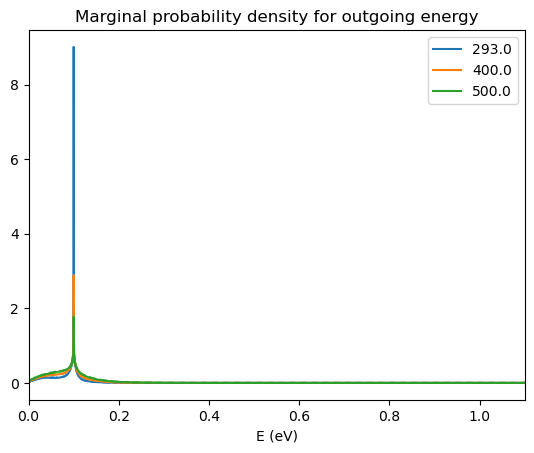

In [9]:
Ein = 0.1

pj = [PavlouJiTable(Ein, T, td) for T in Tvals]
pj_notrans = [PavlouJiTable(Ein, T, td_notrans) for T in Tvals]

lines = []
for i in range(3):
    l, = plt.plot(pj[i].valid_betas * pj[i].T * kb+Ein, pj[i].beta_densities, color='C%i'%i)
    lines.append(l)
    plt.plot(pj[i].valid_betas * pj[i].T * kb+Ein, pj_notrans[i].beta_densities, linestyle='--', color='C%i'%i)

# plt.plot(pj_notrans.valid_betas, pj_notrans.beta_densities)
plt.legend(lines, Tvals)
plt.xlim([0, Ein+1])
# plt.ylim([0, Ein])
plt.xlabel('E (eV)')
plt.title('Marginal probability density for outgoing energy')

## Check that the two components for the mixed distribution sum to NJOY's normal output

In [10]:
# energy values to evaluate at
Evals = np.logspace(-4, np.log10(5.0), 100)
c_integral = np.zeros((len(Evals), len(Tvals)))
t_integral = np.zeros((len(Evals), len(Tvals)))
for i_E, Ein in enumerate(Evals):
    print('%i/%i'%(i_E+1,len(Evals)), end='\r')
    for i_T, T in enumerate(Tvals):
        pj = PavlouJiTable(Ein, T, td, td_t=td_tran_only, td_c=td_conv_only)
        c_integral[i_E, i_T] = pj.c_integral
        t_integral[i_E, i_T] = pj.t_integral


In [11]:
mixfrac = t_integral/(c_integral+t_integral)

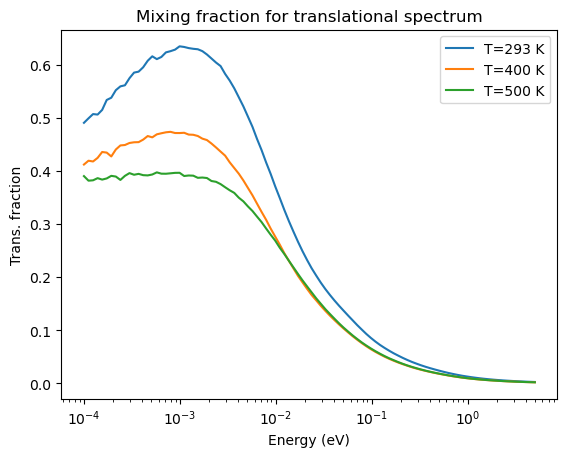

In [12]:
plt.semilogx(Evals, mixfrac)
# plt.semilogx(Evals, t_integral)

plt.legend(['T=%i K'%t for t in Tvals])
plt.xlabel('Energy (eV)')
plt.ylabel('Trans. fraction')
plt.title('Mixing fraction for translational spectrum')
plt.savefig('mixing_fraction.pdf')

## Checking that my sampling method can match the combined beta distribution

In [13]:
## The below sets up the interface to the C++ routines for sampling the pertinent distributions.
import ctypes
es = ctypes.CDLL("./sample_egelstaff.so")
es.sample_egelstaff_schofield.restype = None
es.sample_egelstaff_schofield_rejection.restype = None

es.sample_egelstaff_schofield_given_alpha.restype = None
es.sample_egelstaff_schofield_given_alpha_bounded.restype = None


cd = ctypes.c_double
cdp = ctypes.POINTER(cd)

# This function samples both beta and alpha.
cs = (cd, #A
      cd, #Ein
      cd, #T
     cd, #wt
     cd, #c
     cd, #lambda
     ctypes.c_uint64, #seed
     cdp, # *alpha
     cdp) # *beta
es.sample_egelstaff_schofield.argtypes = cs
es.sample_egelstaff_schofield_rejection.argtypes = cs

# This one requires that you pass in alpha, and
# it samples beta given that alpha.
es.sample_egelstaff_schofield_given_alpha.argtypes = (cd,
                                          cd,
                                          cd,
                                         cd,
                                         cd,
                                         ctypes.c_uint64,
                                         cd,
                                         cdp)
es.sample_egelstaff_schofield_given_alpha_bounded.argtypes = (cd,
                                          cd,
                                          cd,
                                         cd,
                                         cd,
                                         ctypes.c_uint64,
                                         cd,
                                         cd,
                                         cdp)
beta_es = ctypes.c_double(0.0)
alpha_es = ctypes.c_double(0.0)

## Check for match with pure translational part

In [14]:
n_samples = int(1e5)
i_T = 0 # 293, 400, or 500
Ein = 0.025

T = Tvals[i_T]

pj = PavlouJiTable(Ein, T, td_tran_only)
a_pj = np.zeros(n_samples)
b_pj = np.zeros(n_samples)
# derived quantities
this_wt = twt[i_T]
this_c = c[i_T]
# this_c = 100
# this_wt*=0.5
for i in trange(n_samples):
    a, b = pj.sample()
    a_pj[i] = a
    b_pj[i] = b

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 42823.10it/s]


In [15]:
# check how my code is sampling from this distribution
a_es = np.zeros(n_samples)
b_es = np.zeros(n_samples)
dw_lambda = td.inelastic.data['debye_waller_lambda'](T)

for i in trange(n_samples):
    es.sample_egelstaff_schofield(A, Ein, T, this_wt,
                      this_c, dw_lambda,
                      np.random.randint(1, 9223372036854775807),
                      ctypes.byref(alpha_es),
                      ctypes.byref(beta_es))

    a_es[i] = alpha_es.value
    b_es[i] = beta_es.value

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 109884.92it/s]


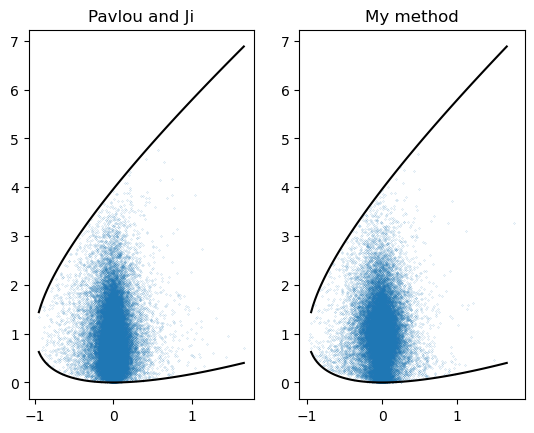

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(b_pj, a_pj, s=0.01)
ax2.scatter(b_es, a_es, s=0.01)
ax1.set_title('Pavlou and Ji')
ax2.set_title('My method')

b_vals = np.linspace(np.min(b_pj), np.max(b_pj), 100)
amin, amax = get_alpha_bounds(Ein, b_vals, kb * T, A)
for a in (ax1, ax2):
    a.plot(b_vals, amin,color='black')
    a.plot(b_vals, amax, color='black')

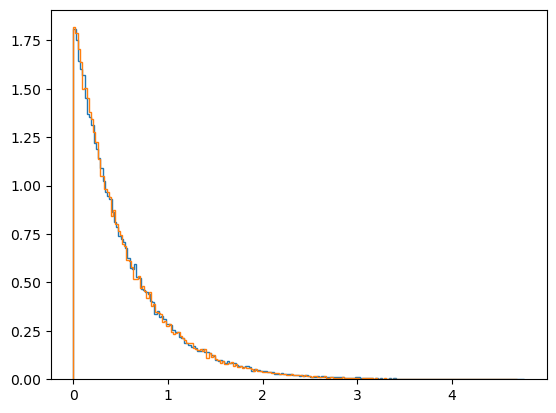

In [17]:
h = plt.hist(a_pj,bins=200, density=True, histtype='step')
h2 = plt.hist(a_es, bins=200, density=True, histtype='step')

## Sampling the full scattering law

In [19]:
# Parameters for sampling to be carried out
i_T = 0 # 293, 400, or 500
n_samples = int(1e6)
Ein = 1.0

# derived quantities
T = Tvals[i_T]
this_wt = twt[i_T]
this_c = c[i_T]
frc = np.interp(Ein, Evals, mixfrac[:, i_T]) # mixing fraction
dw_lambda = td.inelastic.data['debye_waller_lambda'](T)

# frc = 0.9
# Build a Pavlou and Ji table for sampling the part of
# the law coming from a phonon expansion, i.e. the solid
# part. In practice the phonon sampling method is used here.
pj_solidonly = PavlouJiTable(Ein, T, td_notrans)
pj_reference = PavlouJiTable(Ein, T, td)

# These are used to accumulate the rejection efficiency
# of the envelope selection for the convolutional sampling
# part.
n_conv_sam = 0
n_rej_conv_sam = 0

alpha_samples = np.zeros(n_samples)
beta_samples = np.zeros(n_samples)
for i in trange(n_samples):
    # sometimes sample the E&S quasi-elastic part
    if np.random.uniform() < frc:
        es.sample_egelstaff_schofield_rejection(A, Ein, T, this_wt,
                          this_c, dw_lambda,
                          np.random.randint(1, 9223372036854775807),
                          ctypes.byref(alpha_es),
                          ctypes.byref(beta_es))
        alpha_samples[i] = alpha_es.value
        beta_samples[i] = beta_es.value
    else:
        # Sample from the convolution in beta of the E&S law
        # and the solid part of the law from phonon expansion.
        # There is no shape in alpha for the S_trans law; it
        # can be written as P(beta|alpha) without a marginal
        # in alpha. Consequently we sample beta and alpha from
        # the solid law, then simply add a beta value sampled
        # from the E&S law conditioned at that alpha to sample
        # from the convolved distribution.
#         while True:
#             alpha, beta_solid = pj_solidonly.sample()
            
#             # sample the additional beta from the translational contribution
#             es.sample_egelstaff_schofield_given_alpha(A, Ein, T, this_wt,
#                                   this_c, np.random.randint(1, 9223372036854775807),
#                                   alpha,
#                                   ctypes.byref(beta_es))
#             beta = beta_solid + beta_es.value
            
#             # allowable bounds for beta given alpha.
#             rt_alpha_hat = np.sqrt(A * kb * T * alpha / Ein)
#             beta_min = A * (1.0 - 2 / rt_alpha_hat) * alpha
#             beta_max = A * (1.0 + 2 / rt_alpha_hat) * alpha
            
#             # Check for acceptance
#             if beta_min < beta < beta_max:
#                 alpha_samples[i] = alpha
#                 beta_samples[i] = beta
#                 break
        
#         REJECTION FREE APPROACH (INTRODUCES A TINY LITTLE ERROR)
        alpha, beta_solid = pj_solidonly.sample()
        # sample the additional beta from the translational contribution
        es.sample_egelstaff_schofield_given_alpha_bounded(A, Ein, T, this_wt,
                              this_c, np.random.randint(1, 9223372036854775807),
                              alpha,
                              beta_solid,
                              ctypes.byref(beta_es))
        beta = beta_solid + beta_es.value
        alpha_samples[i] = alpha
        beta_samples[i] = beta

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:38<00:00, 26268.01it/s]


## Check if the approximate erf sampling method works

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 121718.36it/s]


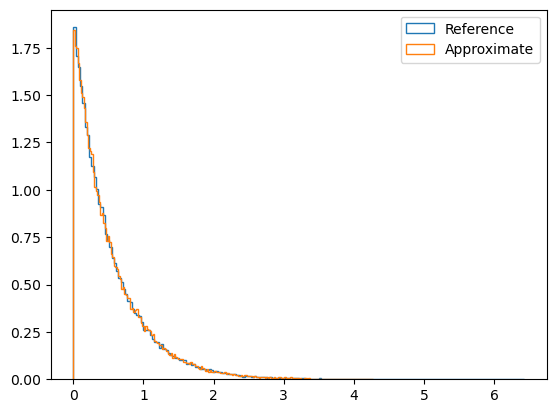

In [20]:
n_samples = int(1e5)

a_rej = np.zeros(n_samples)
b_rej = np.zeros(n_samples)
a_erf = np.zeros(n_samples)
b_erf = np.zeros(n_samples)

# sample from the rejection-based method
for i in trange(n_samples):
    es.sample_egelstaff_schofield_rejection(A, Ein, T, this_wt,
                  this_c, dw_lambda,
                  np.random.randint(1, 9223372036854775807),
                  ctypes.byref(alpha_es),
                  ctypes.byref(beta_es))
    a_rej[i] = alpha_es.value
    b_rej[i] = beta_es.value 

# sample from the approximation-based method
for i in trange(n_samples):
    es.sample_egelstaff_schofield(A, Ein, T, this_wt,
                  this_c, dw_lambda,
                  np.random.randint(1, 9223372036854775807),
                  ctypes.byref(alpha_es),
                  ctypes.byref(beta_es))
    a_erf[i] = alpha_es.value
    b_erf[i] = beta_es.value

h1 = plt.hist(a_rej, bins=200, histtype='step', density=True, color='C0')
h2 = plt.hist(a_erf, bins=200, histtype='step', density=True, color='C1')
plt.legend(['Reference', 'Approximate'])

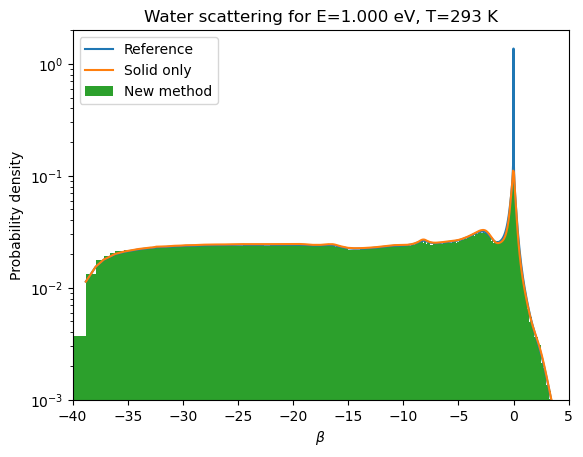

In [21]:
plt.plot(pj_reference.valid_betas, pj_reference.beta_densities)
plt.plot(pj_solidonly.valid_betas, pj_solidonly.beta_densities)
h = plt.hist(beta_samples, density=True, bins=pj_reference.betas)#, histtype='step')

plt.xlim([-40, 5])
plt.ylim([1e-3, 2])

plt.legend(('Reference', 'Solid only', 'New method'))
plt.title('Water scattering for E=%.3f eV, T=%.0f K'%(Ein, T))
plt.yscale('log')
plt.ylabel('Probability density')
plt.xlabel('$\\beta$')
plt.savefig('water_T%.2f_E%.3e.pdf'%(T, Ein), dpi=300)

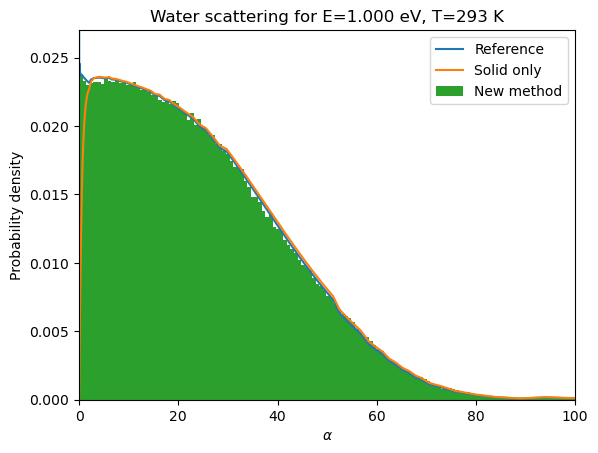

In [22]:
# view alpha marginal
plt.plot(pj_reference.alpha_marginal_alphas, pj_reference.alpha_marginal)
plt.plot(pj_solidonly.alpha_marginal_alphas, pj_solidonly.alpha_marginal)
h = plt.hist(alpha_samples, density=True, bins=200)
plt.xlabel('$\\alpha$')
plt.ylabel('Probability density')
plt.legend(('Reference', 'Solid only', 'New method'))
plt.title('Water scattering for E=%.3f eV, T=%.0f K'%(Ein, T))


plt.xlim([0, 100.0])
plt.ylim([0, 0.027])
# plt.yscale('log')
plt.savefig('water_alpha_T%.2f_E%.3e.pdf'%(T, Ein))

In [23]:
# view marginal for mu (little more interesting!)
n_samples = int(1e6)
def mu(a, b):
    fac = kb*T/Ein
    mu_samples = (2.0 + b*fac - A * a * fac) / (2.0 * np.sqrt(1.0 + b*fac))
    return mu_samples

# get samples for the two other methods. Tricky to compute mu distribution from S(a, b)
alpha_ref = np.zeros(n_samples)
beta_ref = np.zeros(n_samples)
for i in trange(n_samples):
    a, b = pj_reference.sample()
    alpha_ref[i] = a
    beta_ref[i] = b


alpha_sol = np.zeros(n_samples)
beta_sol = np.zeros(n_samples)
for i in trange(n_samples):
    a, b = pj_solidonly.sample()
    alpha_sol[i] = a
    beta_sol[i] = b

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:17<00:00, 56343.68it/s]


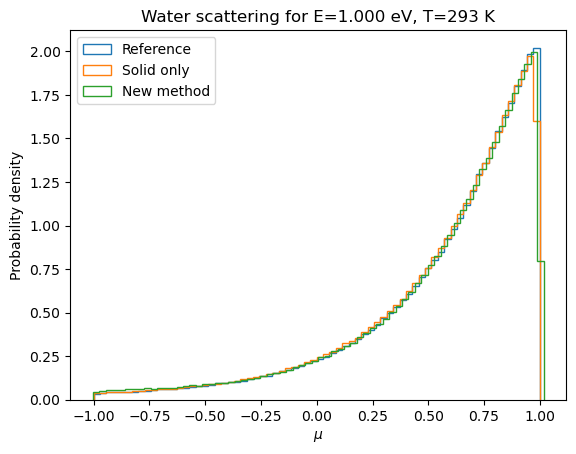

In [24]:
mu_ref = mu(alpha_ref, beta_ref)
mu_sol = mu(alpha_sol, beta_sol)
mu_new = mu(alpha_samples, beta_samples)

href = plt.hist(mu_ref, bins=70, density=True, histtype='step')
hsol = plt.hist(mu_sol, bins=70, density=True, histtype='step')
h = plt.hist(mu_new, bins=70, density=True, histtype='step')

plt.legend(('Reference', 'Solid only', 'New method'))
plt.xlabel('$\\mu$')
plt.ylabel('Probability density')
plt.title('Water scattering for E=%.3f eV, T=%.0f K'%(Ein, T))
plt.savefig('water_mu_T%.2f_E%.3f.pdf'%(T, Ein))